In [1]:
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import classification_report, confusion_matrix
import numpy as np
import pandas as pd
import json

import matplotlib.pyplot as plt
from matplotlib import cm
import seaborn as sns

## Data Preprocessing and Feature Engineering

### Splitting the dataframe
To split the dataframe into the `X_train` and `X_eval` dataframes based off whether the value in the `"evaluation set"` column is $0.0$ or $1.0$, we will import the `"data/kickstarter.csv"` dataframe and implement a function, `train_eval_split`, that does just that.

In [2]:
df = pd.read_csv("data/kickstarter.csv")

In [3]:
def train_eval_split(df):
    
    """
    Splits the dataframe into two dataframes, X_train and X_eval, depending on
    whether the value in the 'evaluation_set' column is 0.0 or 1.0.
    """
    
    df_copy = df.copy()
    
    evaluate_mask = df_copy['evaluation_set']
    
    X_eval = df_copy.loc[evaluate_mask].iloc[:, :-1]
    X_train = df_copy.loc[~evaluate_mask].iloc[:, :-1]
    
    return X_train, X_eval

X_train, X_eval = train_eval_split(df)

### Determining the importance of a column with discrete values to a project's success
To determine whether a column with discrete values is of importance to a project's success, we will implement a function, named `get_success_rates` to return a dictionary describing the proportion of projects that succeeded when the value in that column was each of discrete values specified.

In [58]:
def get_success_rates(df, column, options=None, success_column='state'):
    
    """
    Returns a dictionary with the keys being the values that a column can take and the corresponding
    values being the proportion of projects with that value in that column that succeeded.
    
    If the options parameter (a list of the column's possible values) is left blank, it defaults
    to a list of unique values in that column
    
    Useful for deciding whether a column considerably changes the probability of a project's success.
    """
    
    success_rates = {}
    
    if options is None:
        options = df[column].unique()
    
    for option in options:
        
        is_option = df[column] == option
        value_counts = df.loc[is_option][success_column].value_counts().to_dict()
        
        successes = value_counts[1.0] if 1.0 in value_counts.keys() else 0
        failures = value_counts[0.0] if 0.0 in value_counts.keys() else 0
        
        success_rate = (successes / (successes + failures))
        success_rates[option] = success_rate
                        
    return success_rates


If the aforementioned column is found to be significant to a project's success (i.e. the success rate differs considerably amongst the discrete values that column can take), to quantify the discrete values within this column (if they are non-numeric and non-Boolean), we can replace them with their respective success rates such that they can be processed by the numeric model. The following `insert_success_rates` function does exactly that. By taking a dataframe, the previously calculated success rates, and the column to match the provided success rates dictionary keys to, it adds the column's success rates to the dataframe.

In [59]:
def insert_success_rates(df, column, success_rates, drop_column=False):
    
    """
    Returns the dataframe with an extra "{column}_success_rate" column which is the corresponding
    success rate (specified in the 'success_rates' dictionary) to the values in the specified column.
    """
    
    df_copy = df.copy()
    column_name = "{}_success_rate".format(column)
    
    for option, success_rate in success_rates.items():
        
        is_option = df[column] == option
        df_copy.loc[is_option, column_name] = success_rate
        
    if drop_column:
        df_copy.drop(column, axis=1, inplace=True)
        
    return df_copy

### Dropping inprocessable and redundant columns
We drop at-first-glance redundant (i.e. those with no meaningful, extractable information) and unprocessable (i.e. those with non-Boolean or non-numeric values) columns.

In [60]:
columns_to_drop = [
    'id', 
    'currency', 
    'currency_symbol', 
    'currency_trailing_code', 
    'source_url', 
    'photo', 
    'name', 
    'blurb', 
    'slug', 
    'profile'
]

X_train.drop(columns_to_drop, axis=1, inplace=True) 

At closer inspection, we can see that there are more redundant columns:
- Every entry in the `"is_starred"` and `"is_backing"` columns is either `NaN` or `False`.
- Every entry in the training dataframe for the `"disable_communication"` column is `False`.
- Every entry in the `"friends"` and `"permissions"` columns is either `NaN` or `[]`.

Therefore, we drop these columns.

In [61]:
columns_to_drop = [
    'is_starred',
    'is_backing',
    'disable_communication',
    'friends',
    'permissions'
]

X_train.drop(columns_to_drop, axis=1, inplace=True) 

The `"state"` and `"short_name"` keys of the dictionaries found in the `"location"` column are too specific for success rates (as there are lots of places with only very few projects in them such that they may be given a skewed success rate). Therefore, we drop this column.

In [62]:
X_train.drop('location', axis=1, inplace=True)

### Extracing information from the `"category"` column
The `"category"` column values are all dictionaries (stored as JSON strings) with several keys. The only one of value is the `"name"` key which is linked to the name of the category. Since this a discrete value with a manageable 126 possible values, we can add the success rates for the category column. We then drop the now redundant `"category"` column.

In [63]:
# Replace the "category" column (JSON strings) with the included category names.
X_train['category'] = X_train['category'].apply(lambda category: json.loads(category)['name'])

# Calculate and print the number of unique categories in the "category" column.
num_categories = len(X_train['category'].unique())
print("There are {} unique categories.".format(num_categories))

# Calculate and insert the success rate for each category, and then drop the category column.
category_success_rates = get_success_rates(X_train, 'category')
X_train = insert_success_rates(X_train, 'category', category_success_rates)
X_train.drop('category', axis=1, inplace=True)

There are 126 unique categories.


### Extracing information from the `"country"` column
We can also do the exact same for the `"country"` column (where the country name is stored as a plaintext string). We can see there is a manageable number (21) of unique countries in the dataframe.

In [64]:
# Calculate and print the number of unique countries in the "country" column.
num_countries = len(X_train['country'].unique())
print("There are {} unique countries.".format(num_countries))

# Calculate and insert the success rate for each country, and then drop the "country" column.
country_success_rates = get_success_rates(X_train, 'country')
X_train = insert_success_rates(X_train, 'country', country_success_rates)
X_train.drop('country', axis=1, inplace=True)

There are 21 unique countries.


### Removing outliers in the `"goal_usd"` column
We can standardize the `"goal"` column values by converting them all to US dollars by multiplying the goal by what's in the `"static_usd_rate"` column.

In [65]:
# Convert all the goal amounts to USD. Then drop the "static_usd_rate" and original "goal" columnns
X_train['goal_usd'] = X_train['goal'] * X_train['static_usd_rate']
X_train.drop(['static_usd_rate', 'goal'], axis=1, inplace=True)

We can confirm that the data is vastly lobsided towards the lower end of the `"goal_usd"` column by viewing the percentiles of the `"goal_usd"` column:

In [66]:
percentiles = np.arange(0.0, 1.0, 0.05)
X_train['goal_usd'].describe(percentiles)

count    5.000000e+04
mean     3.841545e+04
std      1.177452e+06
min      7.466057e-01
0%       7.466057e-01
5%       3.500000e+02
10%      6.000000e+02
15%      1.000000e+03
20%      1.278383e+03
25%      1.800000e+03
30%      2.200000e+03
35%      2.841973e+03
40%      3.300000e+03
45%      4.000000e+03
50%      5.000000e+03
55%      5.000000e+03
60%      6.750000e+03
65%      8.000000e+03
70%      1.000000e+04
75%      1.200000e+04
80%      1.500000e+04
85%      2.000000e+04
90%      3.000000e+04
95%      5.327200e+04
max      1.523501e+08
Name: goal_usd, dtype: float64

Only 5% of the projects have a goal greater than $53272$ USD! Considering that the maximum goal is approxmiately $152$ million, we can safely remove the outliers towards the upper end of the `"goals_usd"` column. We can drop the rows with a goal greater than $30000$ USD or a goal less than $200$ USD to remove outliers that may skew the scaling of our model (as even a single huge outlier will make every single inlier goal value much less in proportion to the maximum value in the column, which is how our values are going to be scaled).

To explore this further, we will plot a histrogram of the number of Kickstarter projects agaisnt their goals. To plot a frequency graph (i.e. a histogram) of the continuous values in the `"goal_usd"` column, we need to organise these values into bins (e.g. $1000 < 2000$ USD is a possible bin to group these goal values into bins for counting). The following `get_bins` function decides the bounds for these bins for a specified number of bins and an array of continuous values (e.g. goal values).

In [67]:
def get_bins(values, n_bins=30):
    
    """
    Creates an array of bounds for 'n_bins' equally sized bins for the 
    continous variable in the 'values' pd.Series.
    """
    
    max_value = values.max()
    min_value = values.min()
    value_range = max_value - min_value

    bins = list(np.arange(min_value, max_value, (value_range / n_bins)))
    
    return bins

We can plot the number of Kickstarter projects *(y-axis)* vs the goal *(x-axis)* as a histrogram using this `get_bins` function to group these goal values into bins for counting. We can then restrict the limits for the goal values and drop the rows whose goals aren't within these limits. We can plot a new histogram to review the difference in the new dataframe without the goal outliers. We choose a logarithmic y-scale as the number of Kickstarter projects drastically changes with the goal values (i.e. by orders of magnititude!).

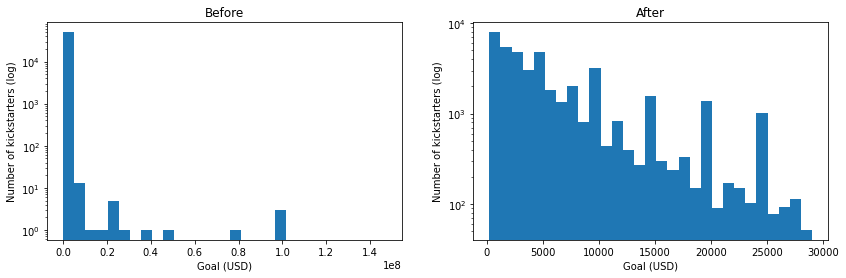

In [68]:
X_train_old = X_train.copy()

GOAL_UPPER_BOUND = 3.0e4
GOAL_LOWER_BOUND = 2.0e2

in_upper = X_train['goal_usd'] < GOAL_UPPER_BOUND
in_lower = X_train['goal_usd'] > GOAL_LOWER_BOUND
X_train = X_train.loc[in_upper & in_lower]

titles = ['Before', 'After']
fig, axs = plt.subplots(1, 2, figsize=(14,4))

for idx, goals in enumerate([X_train_old['goal_usd'], X_train['goal_usd']]):
    
    bins = get_bins(goals)
    axs[idx].hist(goals, bins=bins)
    axs[idx].set_ylabel('Number of kickstarters (log)')
    axs[idx].set_xlabel('Goal (USD)')
    axs[idx].set_yscale('log')
    axs[idx].set_title(titles[idx])
    

Much better! It is clear that our limiting of the `"goal_usd"` column has reduced its spread due to outliers. This will prevent skewing in the later scaling of the `"goal_usd"` column.

### Extracting information from the `"urls"` column

The `"urls"` column contains values that are all dictionaries (stored as JSON strings). These dictionaries contain the URLs (and their types) relating to the project. My logic is that, the more URL types a project has, the more organised it must be and the more likely it is to succeed.  

The following `get_urls` function below extracts the available URL types from a JSON string found in the `"urls"` column:

In [69]:
def get_urls(urls_string):
    
    """
    Returns a list of all the unique url types in a JSON string found in the "urls" column.
    """
    
    urls = []
    urls_dict = json.loads(urls_string)
    
    for url, sub_urls in urls_dict.items():
        
        if url not in urls:
            urls.append(url)
        
        for sub_url in sub_urls:
            
            if sub_url not in urls:
                urls.append(sub_url)
    
    return np.array(urls)


The following `get_df_urls` function essentially does the same thing, but for the whole `"urls"` column in a dataframe (essentially extracting all the possible unique URL types in a dataframe):

In [70]:
def get_df_urls(df):
    
    """
    Returns a list of all the unique url types in an dataframe df.
    """
    
    df_copy = df.copy()
    
    unique_urls = []
    urls_column = df_copy['urls'].apply(get_urls)
    
    for urls in urls_column.to_list():
        
        for url in urls:
            
            if url not in unique_urls:
                
                unique_urls.append(url)
            
    return unique_urls

The following `add_url_features` function adds a column to the dataframe for each unique url type in that dataframe, describing whether the project in that row has that url_type available. Its functionality is dependent on those two defined above.

In [71]:
def add_url_features(df):
    
    """
    For each url type in a dataframe df, add a column 'has_{url_type}' that describes whether
    the project had that url type available.
    """
    
    df_copy = df.copy()
    
    all_urls = get_df_urls(df)
    urls_column = df_copy['urls'].apply(get_urls)
    
    for url in all_urls:
        
        column_name = "has_{}".format(url)
        df_copy[column_name] = urls_column.apply(lambda urls: float(url in urls))
    
    df_copy.drop('urls', axis=1, inplace=True)
    
    return df_copy


We can now add these url features discussed above:

In [72]:
X_train = add_url_features(X_train)
print("The unique url types found in the dataframe are: {}.".format(", ".join(get_df_urls(df))))
X_train[['has_project', 'has_rewards', 'has_web', 'has_message_creator', 'has_star', 'has_api']].value_counts()

The unique url types found in the dataframe are: web, project, rewards, message_creator, api, star.


has_project  has_rewards  has_web  has_message_creator  has_star  has_api
1.0          1.0          1.0      0.0                  0.0       0.0        43125
                                   1.0                  1.0       1.0            3
dtype: int64

However, it seems that every project has a `"project"`, `"rewards"` and `"web"` URL type such that they are redundant. Additionally, the `"has_message_creator"`, `"has_star"` and `"has_api"` columns seem to be mutually inclusive, and there are only 3 projects that have have these URL types. This may a strong indicator for these 3 projects succeeding, but can only be applied for this very small set of projects. It seems that the features we engineered from the `"urls"` column are all redundant and can thus be dropped. We will not include this feature in the final version of the model.

In [73]:
columns_to_drop = [
    'has_project', 
    'has_rewards', 
    'has_web', 
    'has_message_creator', 
    'has_star'
]

X_train.drop(columns_to_drop, axis=1, inplace=True)

### Extracting information from the `"creator"` column

The only noticeable key that is not included in all the dictionaries (stored as JSON strings) in the `"creator"` column is the `"slug"` key. Google, like me, does not seem to know what a "slug" actually *is*. Nevertheless, by creating a `"has_slug"` column in the dataframe (describing whether the creator has provided a slug) we can see, using the aforementioned `get_success_rates` function, that the prescence of this slug actually makes a noticeable difference in the success of the project! We then also drop the original, now redundant, `"creator"` column.

In [74]:
X_train['has_slug'] = X_train['creator'].apply(lambda creator: float('slug' in json.loads(creator).keys()))
X_train.drop('creator', axis=1, inplace=True)
success_rates = get_success_rates(X_train, 'has_slug')

print("Proportion of projects without a slug that succeeded: {:.3f}.".format(success_rates[0.0]))
print("Proportion of projects with a slug that succeeded: {:.3f}.".format(success_rates[1.0]))

Proportion of projects without a slug that succeeded: 0.479.
Proportion of projects with a slug that succeeded: 0.628.


### Extracting information from the `"launched_at"`, `"created_at"` and `"deadline"` columns
To determine whether the time from a project's launch to creation, launch to deadline, and creation to deadline affects the success of a project, we can add columns to the dataframe depicting the quanities listed above. We can then plot a histogram of the proportion and number of projects that succeeded *(y-axis)* agaisnt these continous quanities *(x-axis)* (using bins to group them) to visualise this effect.

In [75]:
X_train['creation_to_launch'] = X_train['launched_at'] - X_train['created_at']
X_train['creation_to_deadline'] = X_train['deadline'] - X_train['created_at']
X_train['launch_to_deadline'] = X_train['deadline'] - X_train['launched_at']

The following `plot_bins` function does exactly this. For each column specified in the provided dataframe, it groups the column's continuous values using the aforementioned `get_bins` function and, if the `do_success_rate` parameter is true, plots a histogram of the proportion of projects in each bin that succeeded *(y-axis)* against these continuous values *(x-axis)*. If `do_success_rate` is explicity set to false, the y-axis will instead depict the number of projects that succeeded in a bin (as opposed to the proportion).

In [76]:
def plot_bins(df, columns, n_bins, do_success_rate=True):
    
    """
    For each of the columns in the dataframe specified, if do_success_rate is true, draw a histogram
    subplot of the success rate (y-axis) vs the continuous values column (x-axis). If not, the histogram subplot
    plots the number of successes (y-axis) vs the column (x-axis). The continuous values in the column
    are grouped into "n_bins" bins.
    """
    
    len_columns = len(columns)
    fig, axs = plt.subplots(1, len_columns, figsize=(14,4))
    fig.tight_layout(pad=4.0)
    
    for idx, column in enumerate(columns):
        
        column_values = df[column]
        bins = get_bins(column_values, n_bins)
        heights = []
        
        start = column_values.min()
        end = column_values.max()
        width = (start - end) / n_bins

        for n_bin in range(0, n_bins-1):

            in_lower = df[column] >= bins[n_bin]
            in_upper = df[column] <= bins[n_bin+1]

            value_counts = df.loc[in_lower & in_upper]['state'].value_counts().to_dict()
            
            successes = value_counts[1.0] if 1.0 in value_counts.keys() else 0
            
            if do_success_rate:
                
                failures = value_counts[0.0] if 0.0 in value_counts.keys() else 0

                if successes == 0 and failures == 0:
                    heights.append(0)
                
                else:
                    
                    success_rate = successes / (successes + failures)
                    heights.append(success_rate)
                    
            else:
                
                heights.append(successes)
        
        if len_columns > 1:
            
            axs[idx].set_ylabel('success_rate' if do_success_rate else 'number of successes')
            axs[idx].set_xlabel(column)
            axs[idx].bar(bins[:-1], heights, width=width)
            
        else: 
            
            axs.set_ylabel('success_rate' if do_success_rate else 'number of successes')
            axs.set_xlabel(column)
            axs.bar(bins[:-1], heights, width=width)
            

We can now create histograms reagarding the quanities we just created:

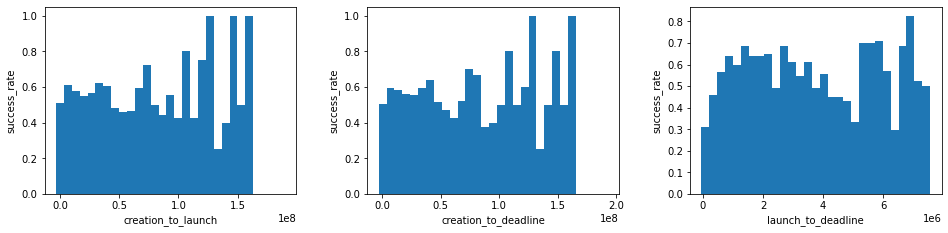

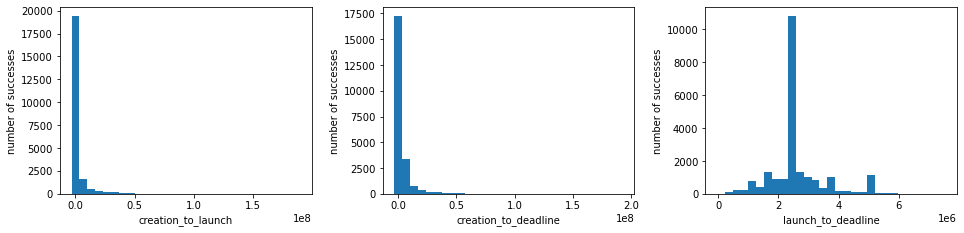

In [77]:
N_BINS = 30

plot_bins(X_train, ['creation_to_launch', 'creation_to_deadline', 'launch_to_deadline'], \
          N_BINS)
plot_bins(X_train, ['creation_to_launch', 'creation_to_deadline', 'launch_to_deadline'], \
          N_BINS, do_success_rate=False)

Unfortunately, there does not seem do be any significant correlation between these quantities and the success rate of projects (apart from the success rate becoming more erratic near the higher, less common values). Therefore, we can drop these redundant quantities.

In [78]:
X_train.drop(['creation_to_launch', 'creation_to_deadline', 'launch_to_deadline'], axis=1, inplace=True)

### Assessing the effect of the `"created_at"`,  `"launched_at"`,  `"deadline"` and `"goal_usd"` columns

We can now also plot histograms of the proportion and number of projects that succeeded against the time of launch, creation and deadline:

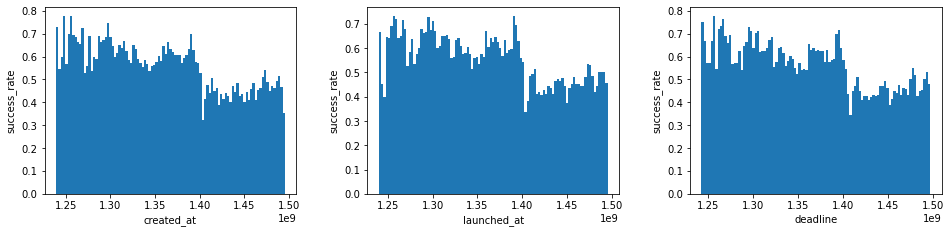

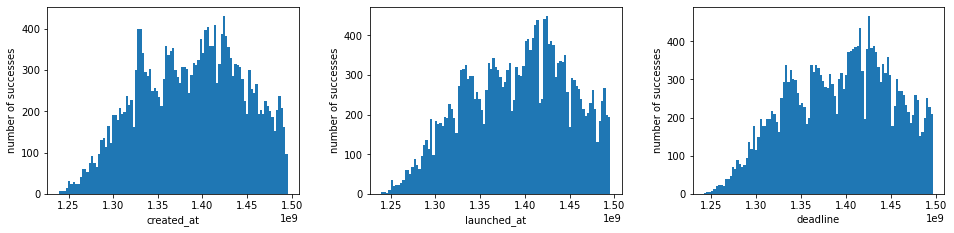

In [79]:
N_BINS = 100

plot_bins(X_train, ['created_at', 'launched_at', 'deadline'], N_BINS, do_success_rate=True)
plot_bins(X_train, ['created_at', 'launched_at', 'deadline'], N_BINS, do_success_rate=False)

We can see there is a considerable negative correlation between the success rate and the time of launch/creation/deadline. It seems the number of successful Kickstarter projects has peaked and is rapidly declining, and that the success rate of projects has recently dipped. However, the 3 histograms on each row display very similar information such that the `"created_at"` and `"deadline"` columns can be dropped in favour of the `"launched_at"` column (which displays the same information and has the greatest aforementioned dip in success rate).

In [80]:
X_train.drop(['created_at', 'deadline'], axis=1, inplace=True)

We can now also plot histograms of the proportion and number of projects that succeeded against the goal:

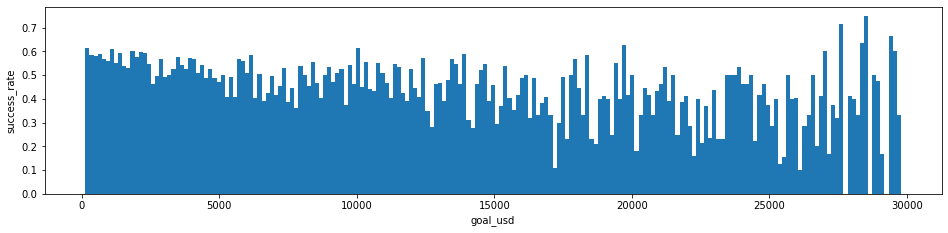

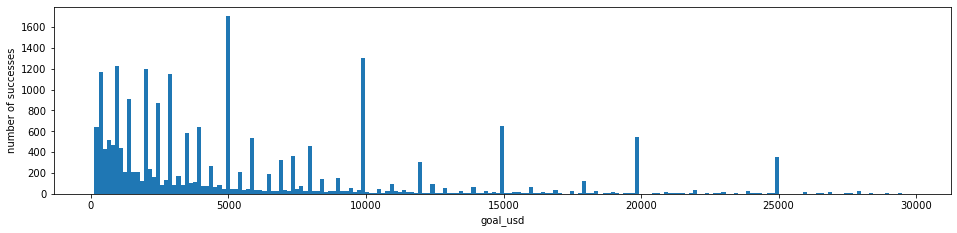

In [81]:
N_BINS = 200
plot_bins(X_train, ['goal_usd'], N_BINS)
plot_bins(X_train, ['goal_usd'], N_BINS, do_success_rate=False)

The proportion and number of projects that have succeeded becomes more erratic and very gradually decreases as the goal increases. On the second graph, we can see a surge in projects with a goal at a round thousand numbers of USD (e.g. at $5000$ USD, $10000$ USD, $15000$ USD and so on). This slight negative linear correlation convinces us to keep the `"goal_usd"` column.

### Creating the final `preprocess` function

We now seek to combine all the transformations to the original dataframe listed above into one, final, `preprocess` function that takes in the original, unsplit and raw dataframe and returns feature engineered and preprocessed dataframes `X` and `X_eval`, as well as the desired output series, `y`. This function cannot have any dependencies on globally defined functions or variables as it must be pasted, by itself, into the web IDE. Therefore, we must copy some of the existing functions into it for this condition to be met.

Firstly, we need to create a `feature_engineer` function which applies all the endorsed transformations discovered above to a dataframe and then scales it accordingly. However, for the model to give consistent predictions, the evaluation dataframe must be scaled based off the MinMaxScaler object produced when scaling the training dataframe. Therefore, the function must have an option to apply a previously created scaler, or return the MinMaxScaler object created if one isn't provided. 

Additionally, to ensure the scaled values in the `"goal_usd"` column are not skewed by the outliers, the scaler is created for the cleaned training dataframe (i.e. the dataframe with the goal outliers removed), then applied to the full training dataframe. Although this will create a few scaled values in the `"goal_usd"` column in the full training dataframe that are greater than $1$ (as the maximum goal value in the full training dataframe is much greater than the cleaned training dataframe), this effect is outweighed by the large majority of inlying goal values in the full testing dataframe that will now be appropriately scaled in relation to one another.

In [82]:
def feature_engineer(df, drop_outliers=False, scaler=None):
    
    """
    Applies all the feature engineering and preprocessing functions applied above to a dataframe,
    then scales it according to whether a previously created scaler object is provided.
    
    Returns the following array:
    [
        <pd.Dataframe>, 
        <pd.Series ("state" column of dataframe)>, 
        <MinMaxScaler (scaler object, if one is created)>
    ]
    """
    
    df_copy = df.copy()
    
    # Removing redundant or unprocessable columns.
    columns_to_keep = [
        'goal', 
        'country',
        'launched_at', 
        'static_usd_rate', 
        'creator', 
        'category',
        'state'
    ]
    df_copy = df_copy[columns_to_keep]
    
    # "goal" column feature engineering and preprocessing.
    df_copy['goal_usd'] = df_copy['goal'] * df_copy['static_usd_rate']
    df_copy.drop(['static_usd_rate', 'goal'], axis=1, inplace=True)
    
    # Drop rows with outliers in the "goal_usd" column.
    if drop_outliers == True:
        
        GOAL_UPPER_BOUND = 3.0e4
        GOAL_LOWER_BOUND = 2.0e2
        
        in_upper = df_copy['goal_usd'] < GOAL_UPPER_BOUND
        in_lower = df_copy['goal_usd'] > GOAL_LOWER_BOUND

        df_copy = df_copy.loc[in_upper & in_lower]
    
    # "creator" column feature engineering and preprocessing.
    df_copy['has_slug'] = df_copy['creator'].apply(lambda creator: float('slug' in json.loads(creator).keys()))
    df_copy.drop('creator', axis=1, inplace=True)
    
    # "category" column feature engineering and preprocessing.
    df_copy['category'] = df_copy['category'].apply(lambda category: json.loads(category)['name'])
    df_copy = insert_success_rates(df_copy, 'category', category_success_rates, drop_column=True)
    
    # "country" column feature engineering and preprocessing.
    df_copy = insert_success_rates(df_copy, 'country', country_success_rates, drop_column=True)
    
    # After dropping outlying rows, create the 'y' pd.Series from the dataframe's "state" column.
    y = df_copy['state']
    df_copy.drop('state', axis=1, inplace=True)   
    return_array = [y]
        
    # Scale the dataframe. If a scaler object is provided, use that to scale the dataframe.
    # Otherwise, create and fit a MinMaxScaler object and use that to scale the dataframe.
    if scaler is None:
        scaler = MinMaxScaler()
        df_copy = pd.DataFrame(scaler.fit_transform(df_copy), columns=df_copy.columns)
        return_array.append(scaler)
        
    else:
        df_copy = pd.DataFrame(scaler.transform(df_copy), columns=df_copy.columns)
            
    return_array.insert(0, df_copy)
    
    return tuple(return_array)


We can now implement this function, its dependencies (e.g. `insert_success_rates` and `get_success_rates`) and the `train_eval_split` function into one, lengthy `preprocess` function, where a dataframe is split into testing and evaluation dataframes, which are then appropriately preprocessed, feature engineered and scaled.

In [83]:
def preprocess(df):
    
    def train_eval_split(df):
        
        df_copy = df.copy()

        evaluate_mask = df_copy['evaluation_set']

        X_eval = df_copy.loc[evaluate_mask].iloc[:, :-1]
        X_train = df_copy.loc[~evaluate_mask].iloc[:, :-1]

        return X_train, X_eval
    
    def get_success_rates(df, column, options=None, success_column='state'):
    
        success_rates = {}

        if options is None:
            options = df[column].unique()

        for option in options:

            is_option = df[column] == option
            value_counts = df.loc[is_option][success_column].value_counts().to_dict()

            successes = value_counts[1.0] if 1.0 in value_counts.keys() else 0
            failures = value_counts[0.0] if 0.0 in value_counts.keys() else 0

            success_rate = (successes / (successes + failures))
            success_rates[option] = success_rate

        return success_rates
    
    def insert_success_rates(df, column, success_rates, drop_column=False):
    
        df_copy = df.copy()
        column_name = "{}_success_rate".format(column)

        for option, success_rate in success_rates.items():

            is_option = df[column] == option
            df_copy.loc[is_option, column_name] = success_rate

        if drop_column:
            df_copy.drop(column, axis=1, inplace=True)

        return df_copy
    
    def feature_engineer(df, drop_outliers=False, scaler=None):

        df_copy = df.copy()
        columns_to_keep = [
            'goal', 
            'country',
            'launched_at', 
            'static_usd_rate', 
            'creator', 
            'category',
            'state'
        ]
        df_copy = df_copy[columns_to_keep]

        df_copy['goal_usd'] = df_copy['goal'] * df_copy['static_usd_rate']
        df_copy.drop(['static_usd_rate', 'goal'], axis=1, inplace=True)

        if drop_outliers == True:

            GOAL_UPPER_BOUND = 3.0e4
            GOAL_LOWER_BOUND = 2.0e2

            in_upper = df_copy['goal_usd'] < GOAL_UPPER_BOUND
            in_lower = df_copy['goal_usd'] > GOAL_LOWER_BOUND

            df_copy = df_copy.loc[in_upper & in_lower]

        df_copy['has_slug'] = df_copy['creator'].apply(lambda creator: float('slug' in json.loads(creator).keys()))
        df_copy.drop('creator', axis=1, inplace=True)

        df_copy['category'] = df_copy['category'].apply(lambda category: json.loads(category)['name'])
        df_copy = insert_success_rates(df_copy, 'category', category_success_rates, drop_column=True)

        df_copy = insert_success_rates(df_copy, 'country', country_success_rates, drop_column=True)

        y = df_copy['state']
        df_copy.drop('state', axis=1, inplace=True)   
        return_array = [y]

        if scaler is None:
            scaler = MinMaxScaler()
            df_copy = pd.DataFrame(scaler.fit_transform(df_copy), columns=df_copy.columns)
            return_array.append(scaler)

        else:
            df_copy = pd.DataFrame(scaler.transform(df_copy), columns=df_copy.columns)

        return_array.insert(0, df_copy)

        return tuple(return_array)
    
    # Split the dataframe into testing and evaluation dataframes.
    X_train, X_eval = train_eval_split(df)
    
    # Create a temporary training dataframe copy to use for retrieveal of the country and category success rates.
    X_temp = X_train.copy()[['country', 'category', 'state']]
    
    # Calculate and define the country_success_rates global variable.
    country_success_rates = get_success_rates(X_temp, 'country')
    
    # Calculate and define the category_success_rates global variable.
    X_temp['category'] = X_temp['category'].apply(lambda category: json.loads(category)['name'])
    category_success_rates = get_success_rates(X_temp, 'category')
    
    # Create a scaler object that isn't skewed by outliers by feature engineering the cleaned training dataframe
    # (i.e. with the drop_outliers option set to True).
    _, _, scaler = feature_engineer(X_train, drop_outliers=True)
    
    # Apply this scaler object to both the full training and evaluation dataframes (i.e. with the drop_outliers
    # option implicity set to False), creating appropriately scaled, 'X', 'X_eval' dataframes and a 'y' series.
    X, y = feature_engineer(X_train, scaler=scaler)
    X_eval, _ = feature_engineer(X_eval, scaler=scaler)
    
    return X, y, X_eval


## Creating and Training a Logistic Regression Model

### Creating the final `train` function

The following `train` function trains a logisitic regression model on the provided training data (consisting of an `X` training dataframe and a `y` series of desired binary outputs). It returns this fitted model as an sklearn `LogisticRegression` object.

In [84]:
def train(X, y):
    
    model = LogisticRegression()
    model.fit(X, y)
    return model

### Creating the final `predict` function

The following `predict` function takes a trained model, `model`, and use its `predict` method to predict the outputs for each row of the provided `X_eval` evaluation dataframe. It returns a series, `y_pred`, of these predictions.

In [85]:
def predict(model, X_eval):
    
    y_pred = model.predict(X_eval)
    return y_pred

### Evaluating the model

We can now run all our previously defined final functions to preprocess and feature-engineer our data, train a logistic regression model on it, and then use that model to predict the values in the missing `"state"` column in the `"X_eval"` dataframe.

In [86]:
X, y, X_eval = preprocess(df)
model = train(X, y)
y_pred = predict(model, X_eval)

Given the absence of correct y-values for the evaluation dataframe, we can evaluate how our model performs on our training dataframe and output series:

In [87]:
y_pred = predict(model, X)
print("Model R2 score: {} \n".format(model.score(X, y)))
print("Model classification report: \n\n", classification_report(y, y_pred))

Model R2 score: 0.71148 

Model classification report: 

               precision    recall  f1-score   support

         0.0       0.69      0.77      0.73     25121
         1.0       0.74      0.65      0.69     24879

    accuracy                           0.71     50000
   macro avg       0.71      0.71      0.71     50000
weighted avg       0.71      0.71      0.71     50000



- **Precision**  Proportion of predictions that result in this type that were correct (i.e. TP / FP + TP).
- **Recall**: Proportion of predictions that are actually this type that were predicted correct (i.e. TP / TP + FN).

Not bad! Our model can predict whether projects in our training dataframe have succeeded to a 71% accuracy level.

### Bonus: Keras feedforward neural network model

As an alternative to the sklearn logistic regression model, we can compile and train a feedforward neural network model using Keras (using its `Sequential` model object). We define 5 input nodes in the input layer, 32 hidden nodes in the first hidden layer, 16 hidden nodes in the second hidden layer, and 1 output node in the output layer. The hidden layer nodes have the `'relu'` activation function, and the output node has a `'sigmoid'` activation function to confine the output between 0 and 1. We use a `'binary_crossentropy'` loss function as this is a binary classification problem and an `'adam'` optimiser (a personal preference).

In [88]:
from tensorflow.keras import Sequential
from tensorflow.keras.layers import Dense

In [89]:
model = Sequential()
model.add(Dense(32, activation='relu', input_dim=5))
model.add(Dense(16, activation='relu'))
model.add(Dense(1, activation='sigmoid'))
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

In [90]:
model.fit(X, y, epochs=200, verbose=False)

In [91]:
scores = model.evaluate(X, y, verbose=False)
print("Training Accuracy: %.2f%%\n" % (scores[1]*100))

Training Accuracy: 72.52%



Our Keras `Sequential` model has an accuracy of approximately 73% when predicting whether projects have succeeded in our training dataframe. A very slight improvement given the significant increase in time when training this model. Therefore, for our final model, we will stick with the sklearn logistic regression model.